In [60]:
import torch
import torch.nn as nn
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, OrderedDict
import pandas as pd
from typing import Union, List

class MathTokenizer:
    def __init__(self, base: int = 10):
        self.base = base
        self.special_tokens = ['[PAD]', '[SOS]', '[EOS]', '[UNK]']
        self.pad_token, self.sos_token, self.eos_token, self.unk_token = self.special_tokens

        
        self.digits = [str(i) for i in range(base)]

        # Vocabulary: special tokens + signs + digit symbols
        self.vocab = self.special_tokens + ['+', '-'] + self.digits
        self.token2id = {tok: idx for idx, tok in enumerate(self.vocab)}
        self.id2token = {idx: tok for tok, idx in self.token2id.items()}

    def _int_to_base(self, n: int) -> List[str]:
        """
        Convert a non-negative integer to its digit list in the current base.
        Returns a list of digit symbols (strings).
        """
        if n == 0:
            return [self.digits[0]]
        digits: List[str] = []
        while n > 0:
            digits.append(self.digits[n % self.base])
            n //= self.base
        return list(reversed(digits))

    def encode(self, sequence: Union[str, List[str]]) -> List[int]:
        """
        Encode a sequence (either a string of single-character tokens or a list of token strings)
        into token IDs, adding SOS and EOS.
        """
        if isinstance(sequence, str):
            # legacy: split string into single-character tokens
            tokens = [self.sos_token] + list(sequence) + [self.eos_token]
        else:
            # sequence is already a list of token strings
            tokens = [self.sos_token] + sequence + [self.eos_token]
        return [self.token2id.get(tok, self.token2id[self.unk_token]) for tok in tokens]

    def decode(self, ids: List[int]) -> List[str]:
        """
        Decode a list of token IDs to the sequence of token strings,
        stripping out special tokens.
        """
        tokens = [self.id2token.get(i, self.unk_token) for i in ids]
        # Remove special tokens
        return [tok for tok in tokens if tok not in (self.sos_token, self.eos_token, self.pad_token)]
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_model) for j in range(d_model)]
            for pos in range(max_len)
        ]
    )
        position_enc = torch.Tensor(position_enc)
        pe = torch.zeros_like(position_enc)
        pe[:, 0::2] = torch.FloatTensor(np.sin(position_enc[:, 0::2]))
        pe[:, 1::2] = torch.FloatTensor(np.cos(position_enc[:, 1::2]))
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:x.size(1)]

class GCDTransformer(nn.Module):
    def __init__(self, tokenizer, d_model=128, nhead=8, num_layers=3, max_length=512, dropout=0.1):
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.vocab)
        
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_length)
        
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc_out = nn.Linear(d_model, self.vocab_size)
        self.pad_id = tokenizer.token2id[tokenizer.pad_token]

    def forward(self, src, tgt):
        # src: (batch_size, src_len)
        # tgt: (batch_size, tgt_len)
        
        # Embedding + positional encoding
        src_emb = self.pos_encoder(self.embedding(src))
        tgt_emb = self.pos_encoder(self.embedding(tgt))
        
        # Create masks
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)
        
        # Key padding masks must be 2D (batch_size, seq_len)
        src_key_padding_mask = (src == self.pad_id)
        tgt_key_padding_mask = (tgt == self.pad_id)
        
        # Transformer forward
        output = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )
        
        return self.fc_out(output)

    def predict(self, a: int, b: int, max_length: int = 20) -> int | None:
        """Predict gcd for integers a and b, in whatever base this tokenizer uses."""
        # 1) Build the input token list properly, not as one big string
        digits_a = self.tokenizer._int_to_base(abs(a))
        digits_b = self.tokenizer._int_to_base(abs(b))
        src_tokens = ['+'] + digits_a + ['+'] + digits_b

        # 2) Encode & send through the model
        src_ids = self.tokenizer.encode(src_tokens)
        src = torch.tensor(src_ids, device=next(self.parameters()).device).unsqueeze(0)

        sos_id = self.tokenizer.token2id[self.tokenizer.sos_token]
        eos_id = self.tokenizer.token2id[self.tokenizer.eos_token]

        tgt_ids = [sos_id]
        for _ in range(max_length):
            tgt = torch.tensor(tgt_ids, device=src.device).unsqueeze(0)
            with torch.no_grad():
                logits = self(src, tgt)
            next_id = logits.argmax(-1)[0, -1].item()
            tgt_ids.append(next_id)
            if next_id == eos_id:
                break

        # 3) Decode the token IDs back to digit‐strings
        pred_tokens = self.tokenizer.decode(tgt_ids[1:])  # skip the SOS

        # 4) Convert the list of digit‐strings into an integer
        try:
            value = 0
            for tok in pred_tokens:
                # skip any stray '+' signs
                if tok == '+':
                    continue
                digit = self.tokenizer.digits.index(tok)
                value = value * self.tokenizer.base + digit
            return value
        except Exception:
            return None


class GCDDataset(Dataset):
    def __init__(self, min_num=1, max_num=100, num_samples=100000, seed=42, test=False, base=10, mix=False, single=False, selected_gcd=None):
        self.rng = np.random.RandomState(seed)
        self.sample_generated = {i:0 for i in range (1,max_num+1)}
        self.tokenizer = MathTokenizer(base)
        self.data = []
        
        for _ in range(num_samples):
            if test:
                gcd = self.rng.randint(1, 101)
                a, b = self.rng.randint(1, max_num, size=2)
                while True:
                    check = math.gcd(a,b)
                    if check == gcd:
                        break
                    elif check > 1:
                        a = int(a / check)
                        b = int(b / check)
                    else:
                        a = gcd * a
                        b = gcd * b
                        
            elif mix:
                uniform = np.random.choice([True, False], p=[0.05, 0.95])
                if uniform:
                    gcd = self.rng.randint(1, 101)
                    a, b = self.rng.randint(1, max_num, size=2)
                    while True:
                        check = math.gcd(a,b)
                        if check == gcd:
                            break
                        elif check > 1:
                            a = int(a / check)
                            b = int(b / check)
                        else:
                            a = gcd * a
                            b = gcd * b
                else:
                    a, b = self.rng.randint(min_num, max_num, size=2)
                    gcd = math.gcd(a, b)
            elif single:
                gcd = selected_gcd
                a, b = self.rng.randint(1, max_num, size=2)
                while True:
                    check = math.gcd(a,b)
                    if check == gcd:
                        break
                    elif check > 1:
                        a = int(a / check)
                        b = int(b / check)
                    else:
                        a = gcd * a
                        b = gcd * b                        
            else:        
                a, b = self.rng.randint(min_num, max_num, size=2)
                gcd = math.gcd(a, b)
                
            self.sample_generated[gcd] += 1
            sign_a = ['+']
            sign_b = ['+']
            
            a = self.tokenizer._int_to_base(abs(a))
            b = self.tokenizer._int_to_base(abs(b))
            gcd = self.tokenizer._int_to_base(abs(gcd))
            
            src = sign_a + a + sign_b + b
            tgt = ["+"] + gcd
            
            self.data.append((
                self.tokenizer.encode(src),
                self.tokenizer.encode(tgt)
            ))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx][0]),
            torch.tensor(self.data[idx][1])
        )

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src = nn.utils.rnn.pad_sequence(src_batch, padding_value=tokenizer.token2id[tokenizer.pad_token], batch_first=True)
    tgt = nn.utils.rnn.pad_sequence(tgt_batch, padding_value=tokenizer.token2id[tokenizer.pad_token], batch_first=True)
    return src, tgt

def base_to_int(s, b):
    num = 0
    for digit in s:
        num = num * b + int(digit)
    return num

def compute_accuracy(model, dataloader, device, max_int, base=10):
    model.eval()
    perfect_sequences = 0
    total_sequences = 0
    gcd_correct = defaultdict(int)
    gcd_total = defaultdict(int)
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            # Get model predictions
            output = model(src, tgt_input)
            preds = output.argmax(-1)
                  
            # 1. Move all sequences to CPU at once
            tgt_np = tgt_output.cpu().numpy()
            preds_np = preds.cpu().numpy()
            pad_id = model.pad_id
            
            # 2. Process all sequences in batch
            for seq_idx in range(tgt_output.shape[0]):
                # Get non-pad tokens
                target_tokens = tgt_np[seq_idx][1:]
                pred_tokens = preds_np[seq_idx][1:]
                
                # Skip empty sequences
                if len(target_tokens) == 0:
                    continue
                
                # Batch decode using tokenizer (more efficient than one-by-one)
                try:
                    correct_gcd = tokenizer.decode(target_tokens)
                    predicted_gcd = tokenizer.decode(pred_tokens)
                    
                    if base!=10:
                        correct_gcd = base_to_int(correct_gcd, base)
                        predicted_gcd = base_to_int(predicted_gcd, base)
                            
                    gcd_total[correct_gcd] += 1
                    if predicted_gcd == correct_gcd:
                        gcd_correct[correct_gcd] += 1
                except (ValueError, AttributeError):
                    continue
    
    # Sort GCD values in ascending order
    sorted_gcds = sorted(gcd_total.keys())
    sorted_per_gcd = OrderedDict((k, gcd_correct[k]/gcd_total[k]) for k in sorted_gcds)
    sorted_correct = OrderedDict((k, gcd_correct[k]) for k in sorted_gcds)
    sorted_total = OrderedDict((k, gcd_total[k]) for k in sorted_gcds)
    
    return {
        'overall_accuracy': sum(gcd_correct.values()) / max(sum(gcd_total.values()), 1),
        'per_gcd_accuracy': sorted_per_gcd,
        'correct_counts': sorted_correct,
        'total_counts': sorted_total,
        'sorted_gcds': sorted_gcds  # List of GCD values in order
    }



In [7]:
# Initialize DataFrame to store results
per_gcd_df = pd.DataFrame()

# Initialize components
validate_step = 1
layers = 2
heads = 4
hidden_dimension = 256
length = 512
lr = 10e-5
batch = 128
max_int = 1000000
sample_size = 10000
dropout = 0
max_epoch = 100
base = 30
tokenizer = MathTokenizer(base)
seed = None
mix = True

model = GCDTransformer(tokenizer, d_model=hidden_dimension, nhead=heads, num_layers=layers, max_length=length, dropout=dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2id[tokenizer.pad_token])

counter = 0

# Collect infos on number of gcd generated
samples_generated = defaultdict(int)


for epoch in range(max_epoch):
    model.train()
    total_loss = 0
    train_dataset = GCDDataset(max_num=max_int, num_samples=3*sample_size, seed=seed, base=base, mix=mix)
    train_dataloader = DataLoader(train_dataset, batch_size=batch, collate_fn=collate_fn, shuffle=True)
    total_sequences = 0
    perfect_sequences = 0
    
    for key in train_dataset.sample_generated:
        samples_generated[key] += train_dataset.sample_generated[key] 

    for src, tgt in train_dataloader:
        src, tgt = src.to(device), tgt.to(device)
        
        # Prepare target input/output
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        optimizer.zero_grad()
        output = model(src, tgt_input)
        
        # Get prediction
        preds = output.argmax(-1)
        
        # Mask out padding tokens
        mask = (tgt_output != tokenizer.token2id[tokenizer.pad_token])
            
        loss = criterion(
            output.reshape(-1, output.size(-1)),
            tgt_output.reshape(-1)
        )
        
        # Compute accuracy
    
        with torch.no_grad():
            mask = (tgt_output != model.pad_id)
            seq_match = (preds == tgt_output) | ~mask
            perfect_sequences += seq_match.all(dim=1).sum().item()
            total_sequences += tgt.size(0)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    counter += 1
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dataloader)}, Accuracy: {perfect_sequences / max(total_sequences, 1)}")
    if counter % validate_step == 0:
        # Accuracy validation
        validation_dataset = GCDDataset(max_num=max_int, num_samples=sample_size, seed=seed, test=True, base=base)
        validation_dataloader = DataLoader(validation_dataset, batch_size=128, collate_fn=collate_fn)
        results = compute_accuracy(model, validation_dataloader, "cuda", max_int=max_int, base=base)
        # Convert per_gcd_accuracy to a DataFrame row
        row = pd.DataFrame({
            'step': counter,
            **results['per_gcd_accuracy']  # Flattens GCDs into columns
        }, index=[0])
        
        # Append to the main DataFrame
        per_gcd_df = pd.concat([per_gcd_df, row], ignore_index=True)
        
        # Optional: Save to CSV periodically
        if counter % (validate_step * 10) == 0:  # Save every 10 validations
            per_gcd_df.to_csv("per_gcd_accuracy_history.csv", index=False)


C:\Users\xw3g19\AppData\Local\Temp\ipykernel_10496\318838242.py:70: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pe[:, 0::2] = torch.FloatTensor(np.sin(position_enc[:, 0::2]))
C:\Users\xw3g19\AppData\Local\Temp\ipykernel_10496\318838242.py:71: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pe[:, 1::2] = torch.FloatTensor(np.cos(position_enc[:, 1::2]))
c:\Users\xw3g19\.conda\envs\deeplearning\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Loss: 0.5631240573335201, Accuracy: 0.6329333333333333


c:\Users\xw3g19\.conda\envs\deeplearning\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 2, Loss: 0.3069797490505462, Accuracy: 0.8142
Epoch 3, Loss: 0.26251207463284754, Accuracy: 0.8327
Epoch 4, Loss: 0.2438865322381892, Accuracy: 0.8386333333333333
Epoch 5, Loss: 0.24252297577071696, Accuracy: 0.8354333333333334
Epoch 6, Loss: 0.22737404276081857, Accuracy: 0.8437666666666667
Epoch 7, Loss: 0.22907966743124292, Accuracy: 0.8422
Epoch 8, Loss: 0.22544032861577704, Accuracy: 0.8406666666666667
Epoch 9, Loss: 0.23189698318217664, Accuracy: 0.8360666666666666
Epoch 10, Loss: 0.2261666771579296, Accuracy: 0.8382666666666667
Epoch 11, Loss: 0.21257987187263813, Accuracy: 0.8487333333333333
Epoch 12, Loss: 0.2109548253264833, Accuracy: 0.8578666666666667
Epoch 13, Loss: 0.1945579410550442, Accuracy: 0.8752666666666666
Epoch 14, Loss: 0.19055678781042706, Accuracy: 0.8798333333333334
Epoch 15, Loss: 0.1852766085970909, Accuracy: 0.8807666666666667
Epoch 16, Loss: 0.1893461451251456, Accuracy: 0.8767
Epoch 17, Loss: 0.18579702019057376, Accuracy: 0.8801
Epoch 18, Loss: 0.1

C:\Users\xw3g19\AppData\Local\Temp\ipykernel_10496\1459827421.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside


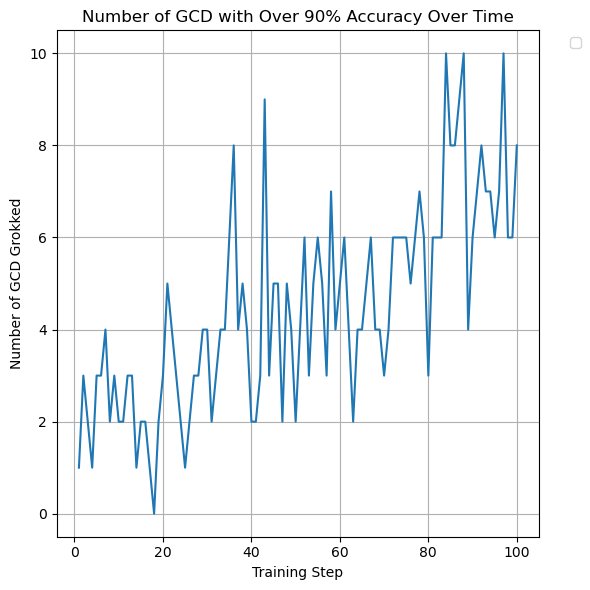

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 6))

grokked = np.zeros(max_epoch)

for i in range(1,max_epoch+1):
    for j in range(1,101):
        if per_gcd_df[per_gcd_df["step"]==i][j].values[0] >= 0.9:
            grokked[i-1] += 1

plt.plot(np.arange(1,max_epoch+1), grokked)
plt.xlabel("Training Step")
plt.ylabel("Number of GCD Grokked")
plt.title("Number of GCD with Over 90% Accuracy Over Time")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()

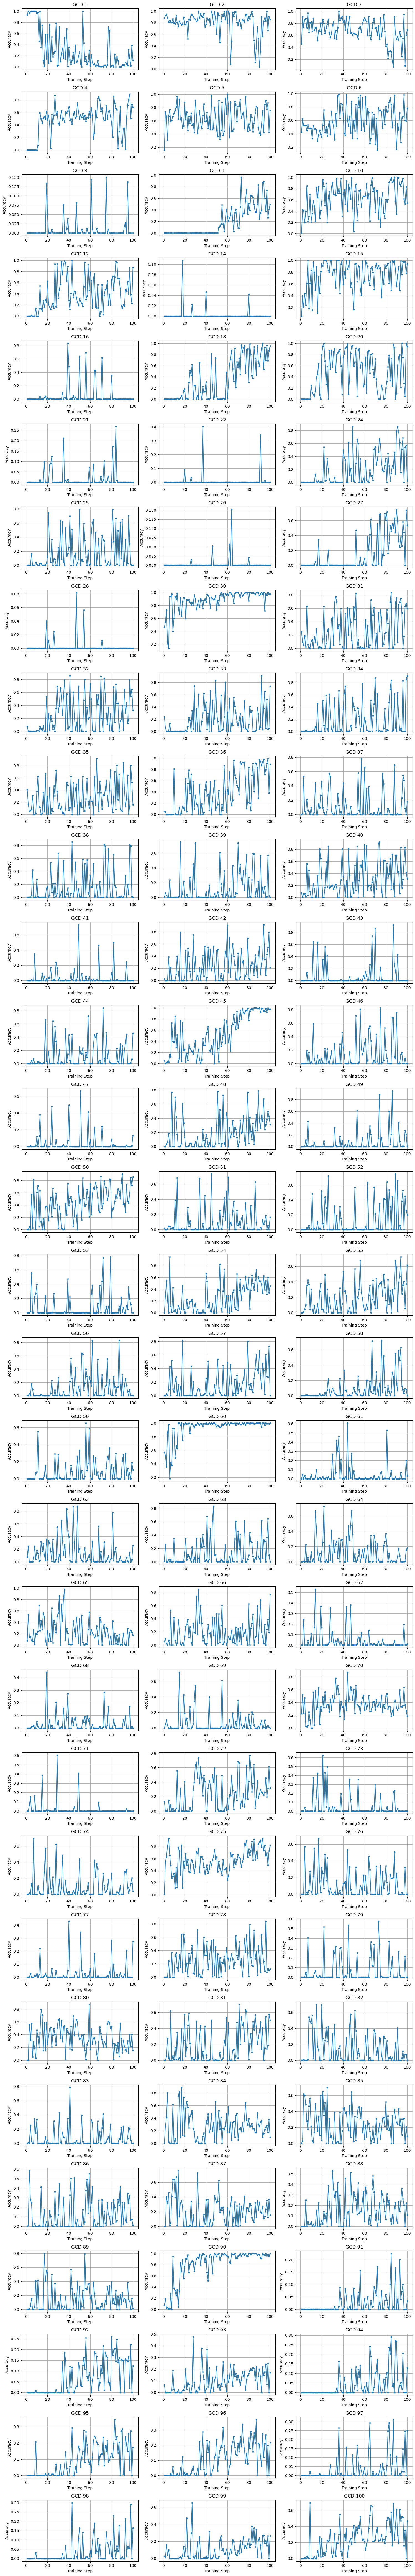

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get the GCD columns (excluding 'step')
gcd_columns = per_gcd_df.columns.drop(['step'])

# Filter GCDs that have more than one unique value and sum > 1
valid_gcds = [gcd for gcd in gcd_columns 
              if len(np.unique(per_gcd_df[gcd])) > 1 and sum(per_gcd_df[gcd]) > 0]

# Determine the layout of subplots
n_gcds = len(valid_gcds)
n_cols = 3  # You can adjust this
n_rows = (n_gcds + n_cols - 1) // n_cols

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
if n_gcds == 1:
    axes = np.array([axes])  # Ensure axes is always an array for consistency
axes = axes.flatten()  # Flatten for easy iteration

# Plot each GCD on its own subplot
for i, gcd in enumerate(valid_gcds):
    ax = axes[i]
    ax.plot(per_gcd_df['step'], per_gcd_df[gcd], marker='.')
    ax.set_title(f'GCD {gcd}')
    ax.set_xlabel("Training Step")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

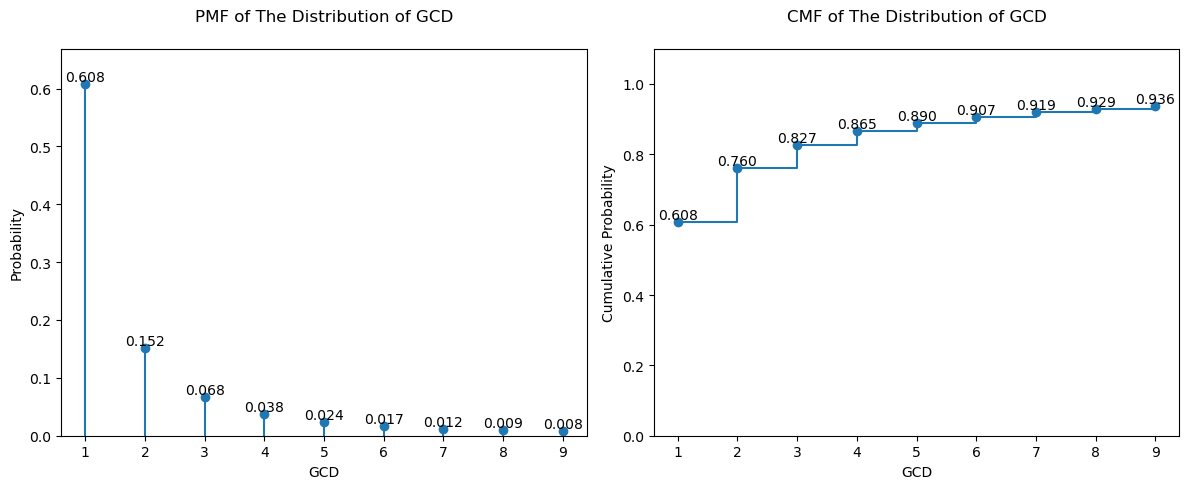

In [66]:
x = np.arange(1, 10)
y = 6 / (np.pi * x)**2
z = np.cumsum(y)  # Cumulative sum is more efficient than list comprehension

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# PMF plot - using stem plot for discrete distribution
markerline, stemlines, baseline = ax[0].stem(x, y, linefmt='C0-', markerfmt='C0o', basefmt=' ')
ax[0].set_title("PMF of The Distribution of GCD", pad=20)
ax[0].set_xlabel("GCD")
ax[0].set_ylabel("Probability")
ax[0].set_xticks(x)  # Ensure only integer ticks
ax[0].set_ylim(0, y.max()*1.1)  # Add some padding at top

# CMF plot - using step plot for discrete cumulative distribution
ax[1].step(x, z, where='post', marker='o')
ax[1].set_title("CMF of The Distribution of GCD", pad=20)
ax[1].set_xlabel("GCD")
ax[1].set_ylabel("Cumulative Probability")
ax[1].set_xticks(x)  # Ensure only integer ticks
ax[1].set_ylim(0, 1.1)  # Cumulative probability can't exceed 1

# Add value labels to both plots
for i, val in enumerate(y):
    ax[0].text(x[i], val, f'{val:.3f}', ha='center', va='bottom')
    
for i, val in enumerate(z):
    ax[1].text(x[i], val, f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [10]:
# Initialize lists to store extracted values
losses = []
accuracies = []

# Read the file
with open('training_log.txt', 'r') as file:
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        if line:  # Skip empty lines
            # Split the line into components
            parts = line.split(', ')
            
            # Extract and convert loss value
            loss = float(parts[1].split(': ')[1])
            losses.append(loss)
            
            # Extract and convert accuracy value
            accuracy = float(parts[2].split(': ')[1])
            accuracies.append(accuracy)

# Print the results
print("Loss values:", losses)
print("\nAccuracy values:", accuracies)

Loss values: [0.5631240573335201, 0.3069797490505462, 0.26251207463284754, 0.2438865322381892, 0.24252297577071696, 0.22737404276081857, 0.22907966743124292, 0.22544032861577704, 0.23189698318217664, 0.2261666771579296, 0.21257987187263813, 0.2109548253264833, 0.1945579410550442, 0.19055678781042706, 0.1852766085970909, 0.1893461451251456, 0.18579702019057376, 0.17521433018623514, 0.18149203816626935, 0.17962432557598074, 0.1747732603169502, 0.1780259459893754, 0.17491489445909542, 0.17669856703661857, 0.17641013464395036, 0.1743432661003255, 0.17248834317668954, 0.17694443876438953, 0.17866706176007047, 0.17152783433173566, 0.17425250151055924, 0.17748636771389778, 0.17003060645879584, 0.1747461514587098, 0.171858770416138, 0.17481877106301327, 0.17193050929840575, 0.17309097603280493, 0.1725512183727102, 0.1732486681418216, 0.16922849087004965, 0.1753369151594791, 0.1744698202673425, 0.16477073491253752, 0.17112780092878543, 0.17300978927536215, 0.1663525398107285, 0.1714975825491103

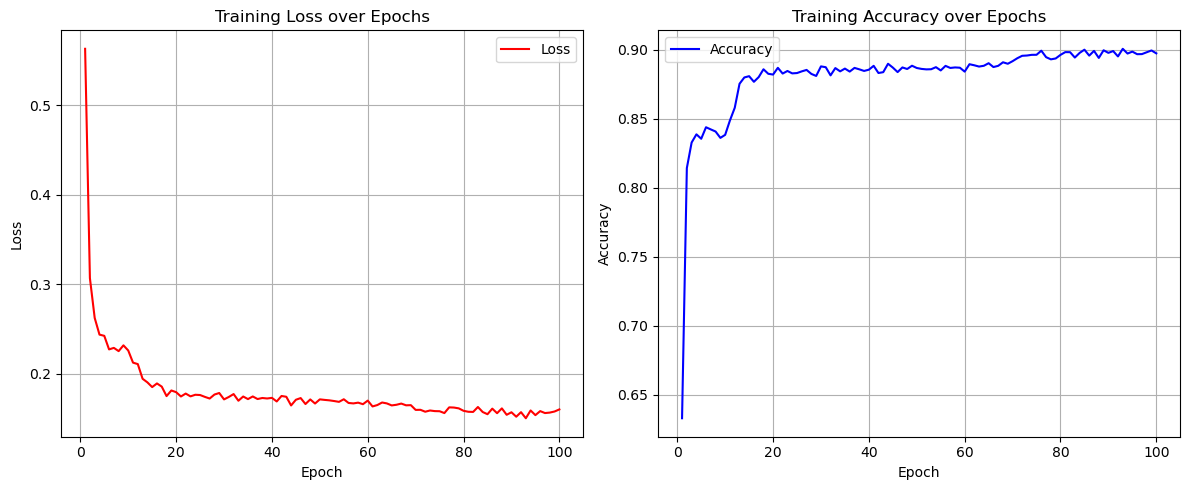

In [11]:
# Data (replace with your extracted lists)
epochs = list(range(1, max_epoch+1))
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Range: [998250, 998300], Loss: 0.2685786648358725, Accuracy: 0.9262
Range: [998250, 998300], Loss: 0.2717662338591829, Accuracy: 0.9299
Range: [998300, 998350], Loss: 0.24010994502260716, Accuracy: 0.9367
Range: [998350, 998400], Loss: 0.2621086177805179, Accuracy: 0.9311
Range: [998400, 998450], Loss: 0.27569756666316264, Accuracy: 0.9244
Range: [998450, 998500], Loss: 0.2521009045782723, Accuracy: 0.9337
Range: [998500, 998550], Loss: 0.2588255245097076, Accuracy: 0.9278
Range: [998550, 998600], Loss: 0.2792557781632942, Accuracy: 0.9322
Range: [998600, 998650], Loss: 0.25727361072845095, Accuracy: 0.9241
Range: [998650, 998700], Loss: 0.24805959648912465, Accuracy: 0.939
Range: [998700, 998750], Loss: 0.27744935500093654, Accuracy: 0.9332
Range: [998750, 998800], Loss: 0.271298779669819, Accuracy: 0.9272
Range: [998800, 998850], Loss: 0.2687276964889297, Accuracy: 0.9264
Range: [998850, 998900], Loss: 0.2664137784438797, Accuracy: 0.931
Range: [998900, 998950], Loss: 0.2643037876467

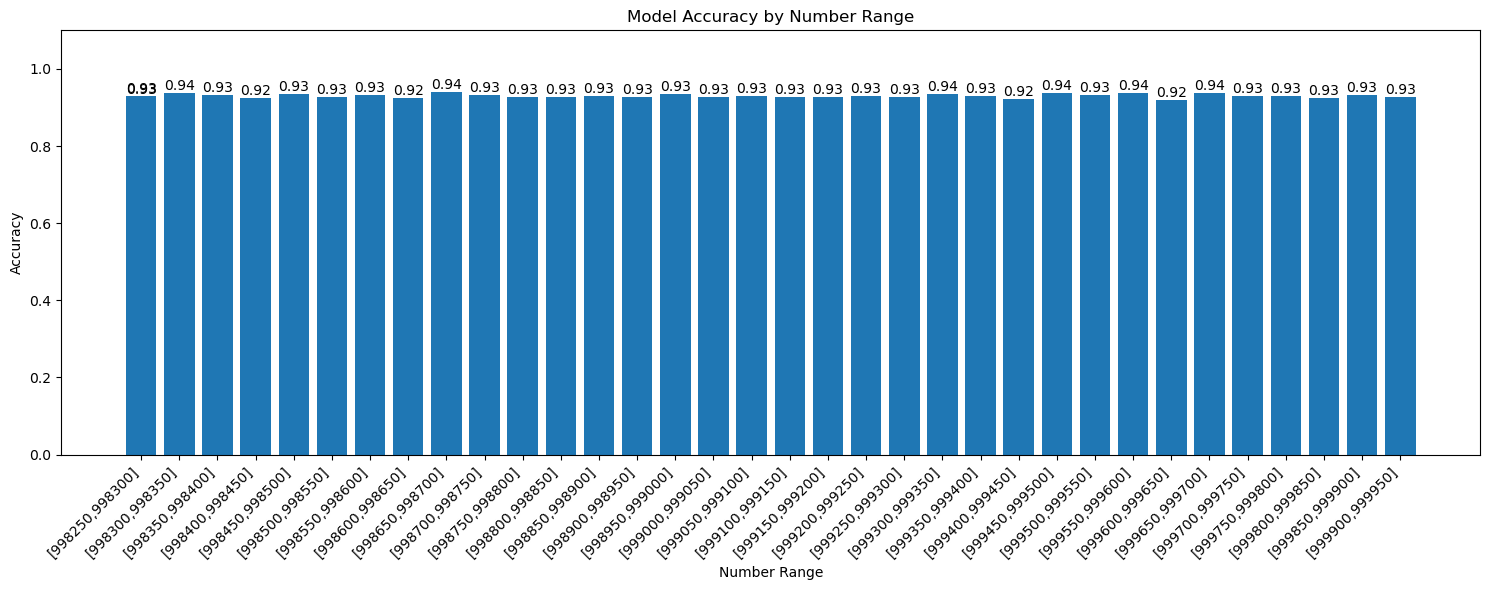

In [ ]:
model.eval()
accuracies = []
ranges = []

for i in range(1, 35):
    # Your existing data loading and evaluation code
    train_dataset = GCDDataset(min_num=(i-1)*50 if i > 1 else 1, 
                              max_num=(i-1)*50+50 if i > 1 else 50, 
                              num_samples=10000, seed=seed, base=base)
    train_dataloader = DataLoader(train_dataset, batch_size=batch, 
                                collate_fn=collate_fn, shuffle=True)

    total_sequences = 0
    perfect_sequences = 0
    total_loss = 0  # Make sure to initialize this if not already done

    for src, tgt in train_dataloader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        output = model(src, tgt_input)
        preds = output.argmax(-1)
        
        with torch.no_grad():
            mask = (tgt_output != model.pad_id)
            seq_match = (preds == tgt_output) | ~mask
            perfect_sequences += seq_match.all(dim=1).sum().item()
            total_sequences += tgt.size(0)
        
        loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
        total_loss += loss.item()

    accuracy = perfect_sequences / max(total_sequences, 1)
    accuracies.append(accuracy)
    
    # Create range labels
    min_val = (i-1)*50 if i > 1 else 1
    max_val = (i-1)*50+50 if i > 1 else 50
    ranges.append(f"[{min_val},{max_val}]")
    
    print(f"Range: [{min_val}, {max_val}], Loss: {total_loss/len(train_dataloader)}, Accuracy: {accuracy}")

# Plotting the histogram
plt.figure(figsize=(15, 6))
bars = plt.bar(ranges, accuracies)

# Customize the plot
plt.xlabel("Number Range")
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Number Range")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim(0, 1.1)  # Set y-axis limits to better show accuracy range

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [ ]:
for epoch in range(max_epoch):
    model.train()
    total_loss = 0
    train_dataset = GCDDataset(max_num=max_int, num_samples=10000, seed=seed, base=base, single=True, selected_gcd=8)
    train_dataloader = DataLoader(train_dataset, batch_size=batch, collate_fn=collate_fn, shuffle=True)
    total_sequences = 0
    perfect_sequences = 0
    
    for key in train_dataset.sample_generated:
        samples_generated[key] += train_dataset.sample_generated[key] 

    for src, tgt in train_dataloader:
        src, tgt = src.to(device), tgt.to(device)
        
        # Prepare target input/output
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        optimizer.zero_grad()
        output = model(src, tgt_input)
        
        # Get prediction
        preds = output.argmax(-1)
        
        # Mask out padding tokens
        mask = (tgt_output != tokenizer.token2id[tokenizer.pad_token])
            
        loss = criterion(
            output.reshape(-1, output.size(-1)),
            tgt_output.reshape(-1)
        )
        
        # Compute accuracy
    
        with torch.no_grad():
            mask = (tgt_output != model.pad_id)
            seq_match = (preds == tgt_output) | ~mask
            perfect_sequences += seq_match.all(dim=1).sum().item()
            total_sequences += tgt.size(0)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    counter += 1
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dataloader)}, Accuracy: {perfect_sequences / max(total_sequences, 1)}")
    if counter % validate_step == 0:
        # Accuracy validation
        validation_dataset = GCDDataset(max_num=max_int, num_samples=sample_size, seed=seed, test=True, base=base)
        validation_dataloader = DataLoader(validation_dataset, batch_size=128, collate_fn=collate_fn)
        results = compute_accuracy(model, validation_dataloader, "cuda", max_int=max_int, base=base)
        # Convert per_gcd_accuracy to a DataFrame row
        row = pd.DataFrame({
            'step': counter,
            **results['per_gcd_accuracy']  # Flattens GCDs into columns
        }, index=[0])
        
        # Append to the main DataFrame
        per_gcd_df = pd.concat([per_gcd_df, row], ignore_index=True)
        
        # Optional: Save to CSV periodically
        if counter % (validate_step * 10) == 0:  # Save every 10 validations
            per_gcd_df.to_csv("per_gcd_accuracy_history.csv", index=False)

c:\Users\xw3g19\.conda\envs\deeplearning\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Loss: 0.006190881026242683, Accuracy: 0.9982
Epoch 2, Loss: 0.15309825258571183, Accuracy: 0.9488


c:\Users\xw3g19\.conda\envs\deeplearning\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 3, Loss: 0.13318055593025505, Accuracy: 0.9232
Epoch 4, Loss: 0.25329320418318335, Accuracy: 0.872
Epoch 5, Loss: 0.15885858864765143, Accuracy: 0.9231
Epoch 6, Loss: 0.13984388953938348, Accuracy: 0.9298
Epoch 7, Loss: 0.25134502261246355, Accuracy: 0.8938
Epoch 8, Loss: 0.09043863188929242, Accuracy: 0.9497
Epoch 9, Loss: 0.20729681287444185, Accuracy: 0.9104


c:\Users\xw3g19\.conda\envs\deeplearning\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 10, Loss: 0.29256666274232895, Accuracy: 0.8718


In [65]:
per_gcd_df

,step,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,1,0.936842,0.880435,0.457143,0.0,0.157895,0.423913,0.0,0.0,0.0,...,0.0,0.0,0.06422,0.0,0.0,0.0,0.0,0.0,0.025000,0.000000
1,2,1.000000,0.923810,0.910891,0.0,0.737374,0.623377,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.011905,0.000000
2,3,0.968421,0.948276,0.732143,0.0,0.669725,0.523810,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.156863,0.000000
3,4,0.989691,0.885714,0.868132,0.0,0.307692,0.520000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.037383,0.010989
4,5,1.000000,0.811321,0.878049,0.0,0.666667,0.527473,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.100000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,114,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
114,115,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
115,116,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
116,117,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.00000,0.0,NaN,0.0,0.0,0.0,0.000000,0.000000
